# Linear Autoregressive Model for Time Series Forecasting

In this notebook, we’ll get hands-on with using a **Linear Autoregressive** model to tackle a forecasting task. Along the way, you’ll explore the implementation details of the model and pick up key ideas that you can apply to your own projects with your own data. By the end, you’ll have a stronger foundation to use **Linear Autoregressive** models for solving your own forecasting problems.

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **GluonTS** for time series modeling  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
# -----------------------------------------------------------
# Imports: Required Libraries for Forecasting Experiments
# -----------------------------------------------------------

# --- Data Manipulation and Numerical Computation ---
import os  # For interacting with the operating system (e.g., file paths)
import pandas as pd  # For handling tabular data
import numpy as np  # For numerical operations on arrays

# --- Data Loading and Preprocessing ---
from datasets import load_dataset  # Hugging Face datasets library for standardized data loading
from genai4t.data.processing import dataset_to_pandas  # Custom utility to convert Hugging Face datasets to pandas DataFrames

# --- Configuration Management and Utilities ---
from omegaconf import OmegaConf  # Hydra-compatible tool for managing experiment configurations
from genai4t.utils import get_torch_device, set_random_state  # Helpers for device selection and reproducibility

# --- Forecasting Model Utilities ---
from genai4t.model.utils import fit_model  # Function to train GluonTS-based models
from genai4t.forecasting.util import create_predictions_dataframe  # Converts model outputs into a pandas DataFrame format
from gluonts.model.forecast import SampleForecast  # GluonTS forecast object used for evaluating model predictions
from gluonts.evaluation.backtest import _to_dataframe # Transform datasets to dataframs
# --- Visualization ---
from matplotlib import pyplot as plt  # For plotting time series and forecasts
from genai4t.plot_style import plot_style # For plotting style
import seaborn as sns 

# --- Miscellaneous ---
from itertools import islice  # Useful for slicing iterables (e.g., previewing data)
from typing import List  # Type hinting support

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        # Whether to use GPU acceleration if available
        # Set to True to enable GPU usage for faster training
        # Will fall back to CPU if GPU is not available
        "use_cuda": True,
        
        # Set random seed for reproducibility
        # Using a fixed seed ensures you get the same results each time you run the code
        # Change this value to get different but still reproducible results
        "random_state": 2024
    }

DATA_CONFIG = {
        # Name of the dataset to load from HuggingFace hub
        # This dataset contains exchange rate data
        "name": "gatam4t/genai4t_exchange_rate",

        # Date to split data into training and test sets
        # Data before this date will be used for training
        # Data after this date will be used for testing
        "split_date": "2016-01-01",

        # Number of future time steps to predict
        "prediction_length": 1,

        # Number of past time steps to use for making predictions
        # Model will look at 30 days of history
        "context_length": 30,

        # Number of sample paths to generate for probabilistic forecasting
        # Higher values give better uncertainty estimates but take longer
        "num_samples": 20,

        # Frequency of the time series data
        # 'B' means business days (Monday-Friday)
        "freq": 'B',

        # Number of time series to process simultaneously during training
        # Larger batch sizes can speed up training but use more memory
        "batch_size": 32,

        # Number of batches in an epoch
        "num_batches_per_epoch": 50,
    }

In [3]:
# --------------------------------------------
# Load Configuration and Set Up Environment
# --------------------------------------------

# Select computation device: GPU (if available) or CPU
device = get_torch_device()

# Set random seed for reproducibility
# Ensures consistent results across multiple runs
set_random_state(ENV_CONFIG["random_state"])

Seed set to 2024


## Load Data

For this experiment, we’ll use the **Exchange Rate** dataset—a multivariate time series dataset commonly used in academic benchmarks for forecasting models. It consists of daily exchange rates for eight currencies (Australia, United Kingdom, Canada, Switzerland, China, Japan, New Zealand, and Singapore)


This dataset was one of the benchmarks used in the evaluation of the **Chronos** paper, and is originally available through the Hugging Face Datasets Hub:

[Original Source (Chronos)](https://huggingface.co/datasets/autogluon/chronos_datasets/viewer/exchange_rate)

To make access easier and ensure long-term reproducibility, a copy of the dataset has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use the Exchange Rate dataset here, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
# ------------------------------------------------------
# Load Dataset from Hugging Face and Convert to Pandas
# ------------------------------------------------------

# Load dataset split from the Hugging Face hub
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
level_data = dataset_to_pandas(dataset).asfreq(DATA_CONFIG["freq"])

# Display the first few rows of the DataFrame
level_data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [5]:
# compute returns
data = np.log(level_data).diff().dropna()
data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-02,-0.004722,-0.000621,-0.000690,-0.001078,0.0,0.003649,0.001685,-0.002885
1990-01-03,0.006248,0.011916,-0.000086,0.023394,0.0,0.016188,0.005540,0.004464
1990-01-04,-0.000890,0.004715,0.001206,0.003248,0.0,-0.003159,-0.000502,-0.004727
1990-01-05,-0.001400,0.009727,-0.000086,0.008625,0.0,-0.001871,0.002509,0.006834
1990-01-08,0.002164,0.000423,-0.001120,-0.002097,0.0,-0.007667,0.009148,-0.002371


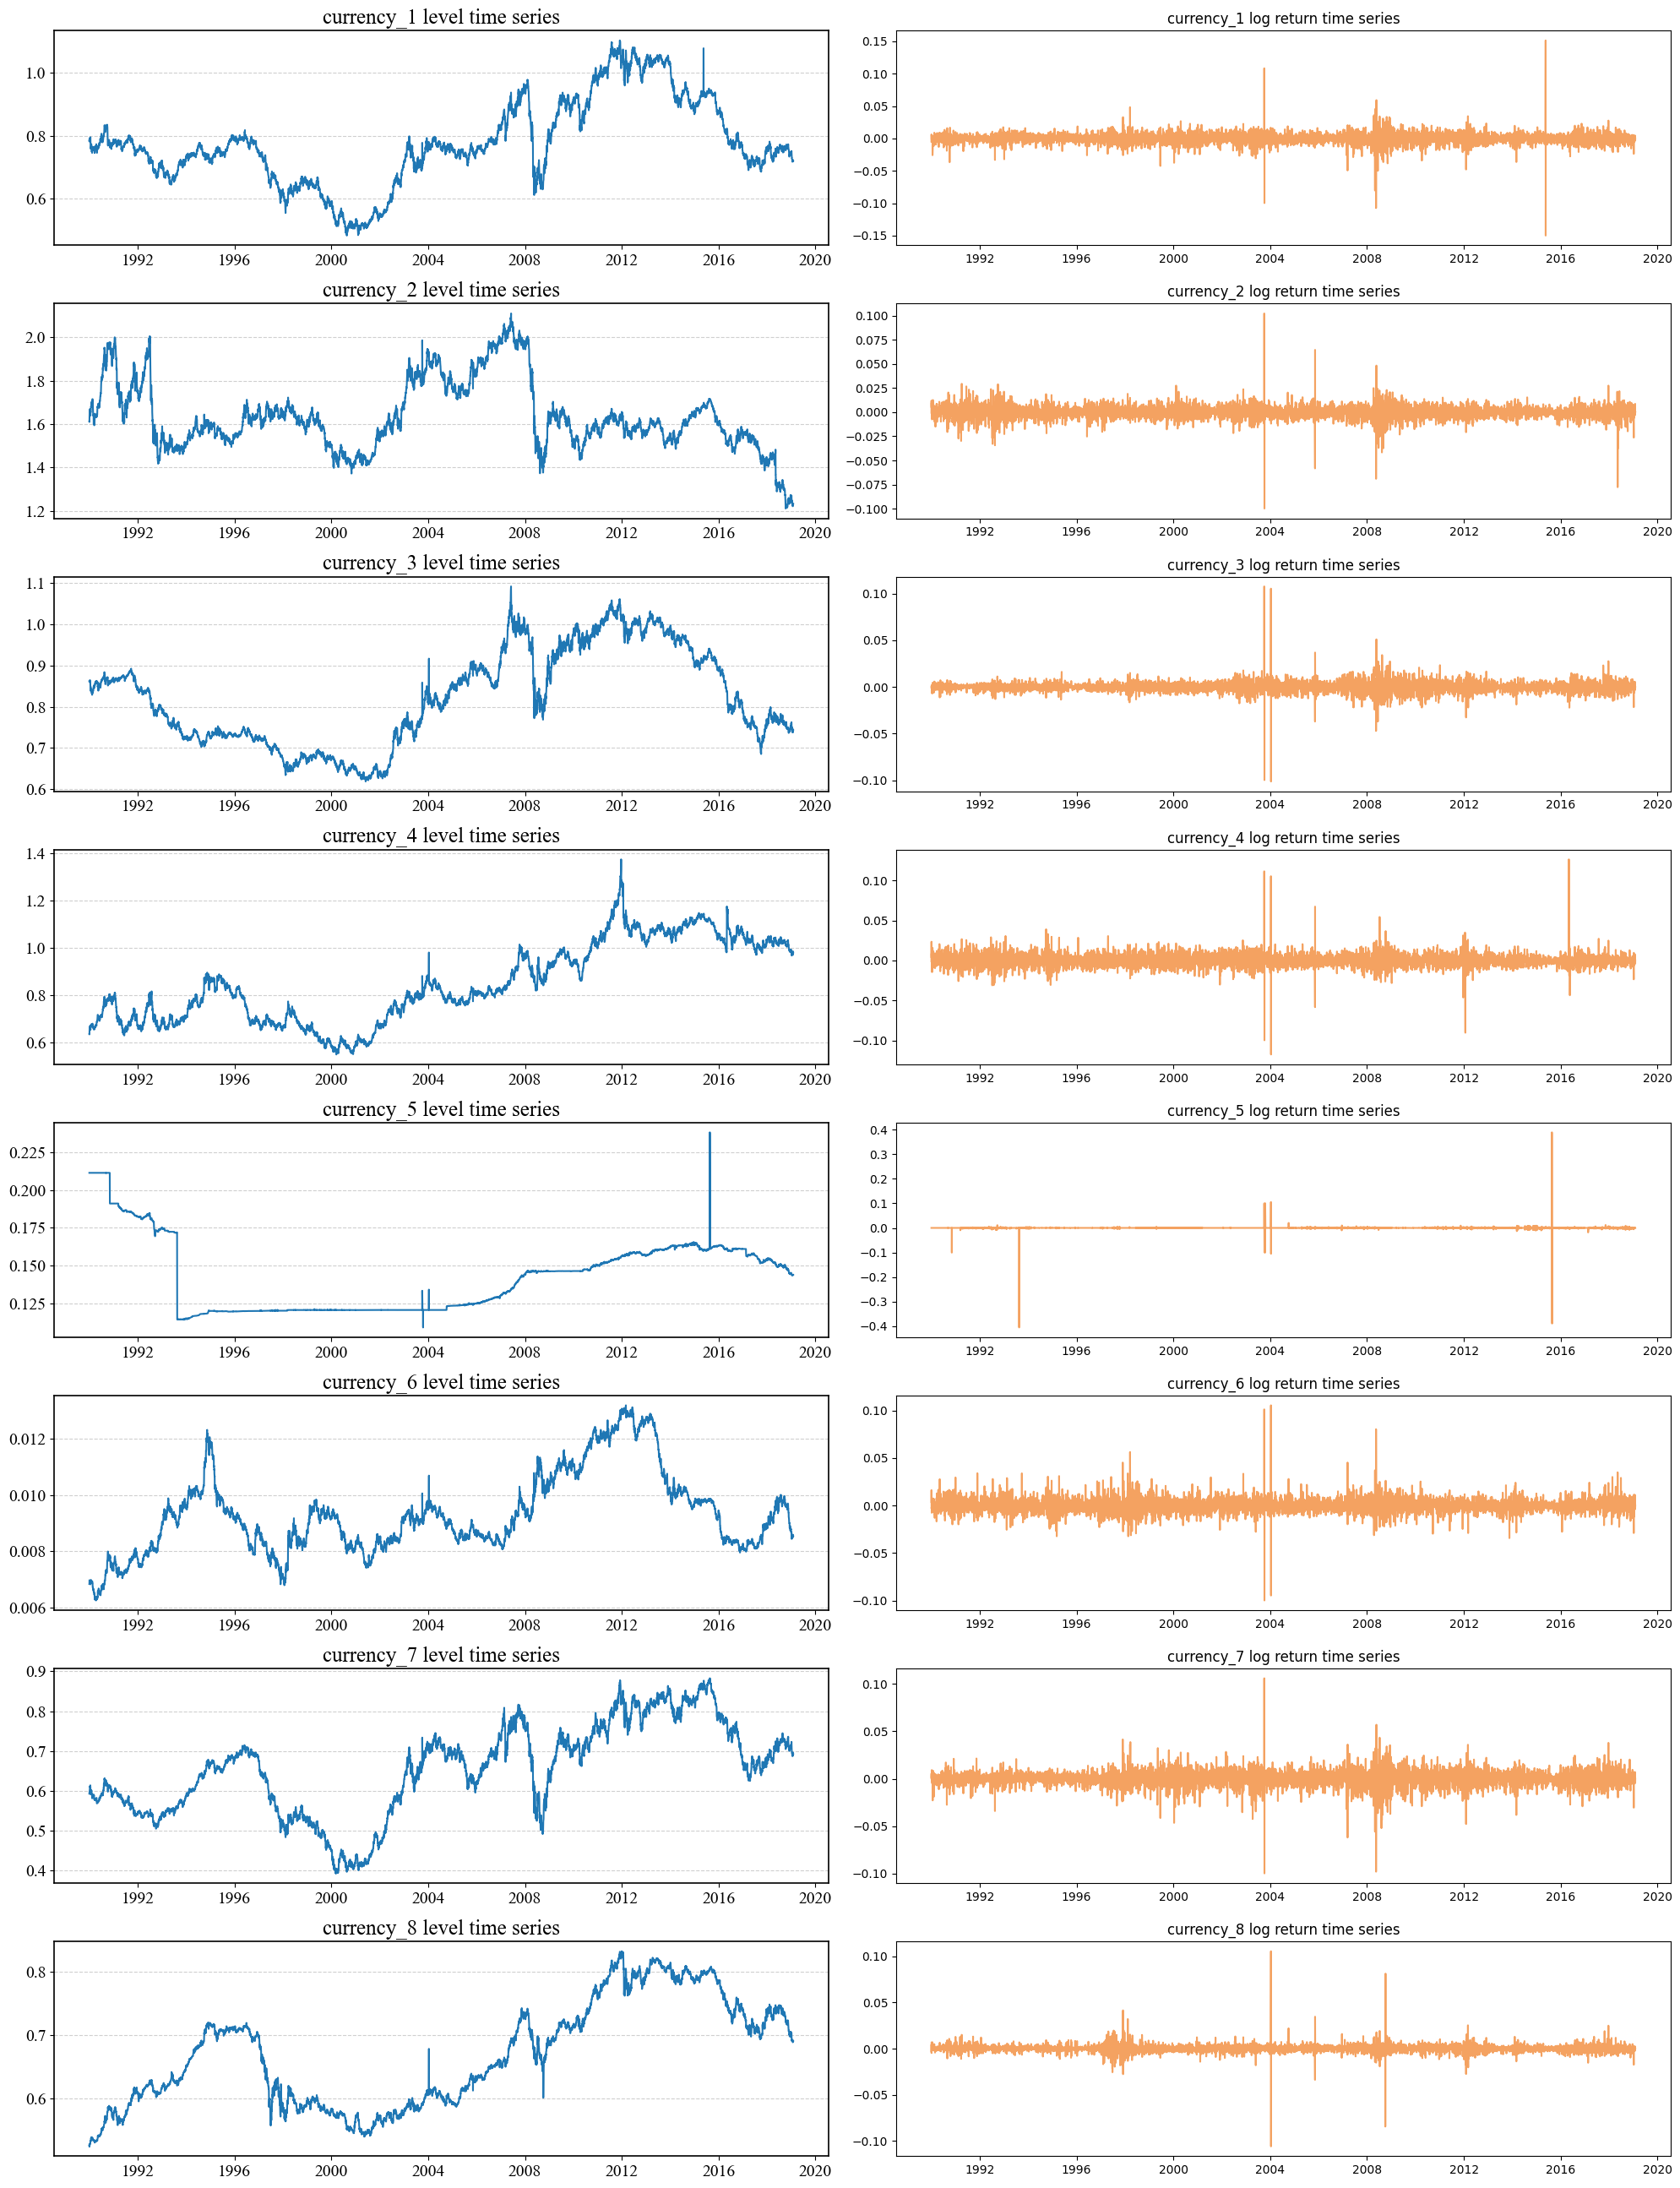

In [6]:
n_series = len(data.columns)
f, axs = plt.subplots(n_series, 2, figsize=(20, 26))
for i, tname in enumerate(data.columns):
    # Plot level time series
    axs[i][0].plot(level_data[tname])
    axs[i][0].set_title(f"{tname} level time series")
    plot_style.apply_plot_style(axs[i][0])
    plot_style.apply_grid(axs[i][0])
    
    # Plot log return time series
    axs[i][1].plot(data[tname], color="#F4A261")
    axs[i][1].set_title(f"{tname} log return time series")
    plot_style.apply_plot_style(axs[i][0])
    plot_style.apply_grid(axs[i][0])

### Convert to GluonTS Format

To use GluonTS models, we need to convert our pandas DataFrame into a **GluonTS-compatible dataset**.

We've already covered how to do this in the `GluonTS Tutorial`, and we've refactored the logic into a utility function called `split_train_test_datasets` for reuse across different notebooks.

In [7]:
from genai4t.forecasting.data import split_train_test_datasets

In [8]:
train_ds, test_ds = split_train_test_datasets(
    data,
    DATA_CONFIG['prediction_length'],
    DATA_CONFIG['split_date'],
    DATA_CONFIG['freq'])

number of windows: 803


## Model: Linear AR

This is one of the simplest models in the book. It serves as a baseline to compare more complex models.

### Architecture

The model `LinearAREstimator` learns a separate linear regression for each future time step using past values of the time series.

The model is trained to minimize the difference between the predicted values and the actual ones using the **Mean Squared Error (MSE) loss**.

Note that this approach uses **Direct Multi-Step (DMS)** forecasting, where we predict all future steps at once, up to the fixed `prediction_length`. It’s different from Autoregressive or **Iterated Multi-Step (IMS)** forecasting, where predictions are made one step at a time and fed back into the model to predict the next step. If we want to forecast further into the future, we need to retrain the model with a longer prediction horizon.

This implementation produces a global model, meaning that no individual models are trained for each time series. Instead, a single model is learned for all eight time series in the Exchange Rate dataset. While this approach may not be optimal for every case, it mirrors the setup used by larger foundation models such as `LagLlama` and `Chronos`.

### Normalization
Because each time series has different value ranges, we apply normalization using the `RobustScaler`, just like `LagLLama`. The normalization is applied in a sliding window, and no global training statistics are used. Feel free to try other types of normalization.

### Implementation
As shown in the `GluonTS` tutorial, we first define a `Lightning` module, then create an estimator to run the model. To keep things simple and avoid repeating code, we use the `BaseEstimator` class. This only requires us to implement the `create_lightning_module` method, since the other methods are already provided with the same functionality as in the tutorial.

In [9]:
from genai4t.model.core import BaseLightningModule
from torch import nn
import torch
from genai4t.forecasting.predictors.util import RobustScaler, BaseEstimator
from typing import Optional, Dict, Any


class LinearARModel(BaseLightningModule):
    """Linear Autoregressive model for time series forecasting.
    
    This class implements a simple linear autoregressive model using PyTorch Lightning.
    It uses a linear layer to predict future values based on past observations.
  
    Attributes:
        context_length (int): Number of past observations used for prediction
        prediction_length (int): Number of future time steps to predict
        linear (nn.Linear): Linear layer for prediction
        _loss (nn.MSELoss): Mean squared error loss function
        scaler (RobustScaler): Robust scaler for input normalization
    """
    
    def __init__(
        self,
        context_length: int,
        prediction_length: int,
        lr: float = 1e-3,
        weight_decay: float = 0.):
        super().__init__(lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()
        
        self.linear = nn.Linear(context_length, prediction_length)
        self._loss = nn.MSELoss()
        self.prediction_length = prediction_length
        self.scaler = RobustScaler(keepdim=True)
        self.context_length = context_length
        
    
    def forward(self, past_target: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.
        
        Args:
            past_target: Input tensor of shape (batch_size, context_length)
                
        Returns:
            Predicted values of shape (batch_size, 1, prediction_length)
        """
        scaled_past_target, loc, scale = self.scaler(past_target)
        scaled_y: torch.Tensor = self.linear(scaled_past_target)
        y: torch.Tensor = scaled_y * scale + loc
        y: torch.Tensor = y[:, torch.newaxis]
        return y

    def step(self, batch):
        """Compute loss for a single training step.
        
        Args:
            batch: Dictionary containing 'past_target' and 'future_target' tensors
                
        Returns:
            Mean squared error loss
        """
        past_target = batch['past_target']
        future_target = batch['future_target'][:, torch.newaxis]
        yhat = self.forward(past_target)
        assert yhat.shape == future_target.shape
        loss = self._loss(yhat, future_target)
        return loss


class LinearAREstimator(BaseEstimator):
    """Estimator class for the LinearAREstimator.
    
    This class handles the training and configuration of the LinearAREstimator.
    
    Attributes:
        prediction_length (int): Number of time steps to predict
        context_length (int): Number of time steps used as input for prediction
        num_steps (int): Number of training steps
        lr (float): Learning rate for optimization
        weight_decay (float): Weight decay (L2 penalty) for optimization
        batch_size (int): Size of training batches
        num_batches_per_epoch (int): Number of batches per training epoch
        trainer_kwargs (Optional[Dict[str, Any]]): Additional arguments for the trainer
    """
    
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        num_steps: int,
        lr: float,
        weight_decay: float,
        batch_size: int,
        num_batches_per_epoch: int,
        trainer_kwargs: Optional[Dict[str, Any]] = None,
    ) -> None:
        super().__init__(
            prediction_length=prediction_length,
            context_length=context_length,
            batch_size=batch_size,
            num_batches_per_epoch=num_batches_per_epoch,
            num_steps=num_steps,
            trainer_kwargs=trainer_kwargs
        )
        self.lr = lr
        self.weight_decay = weight_decay

    def create_lightning_module(self) -> LinearARModel:
        """Create and return a new instance of LinearARModel."""
        return LinearARModel(
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            lr=self.lr,
            weight_decay=self.weight_decay
        )

In [10]:
MODEL_CONFIG = {
    "lr": 1e-3,
    "num_steps": 10_000,
    "weight_decay": 0.,
}

In [11]:
estimator = LinearAREstimator(
    context_length=DATA_CONFIG["context_length"],
    prediction_length=DATA_CONFIG["prediction_length"],
    batch_size=DATA_CONFIG['batch_size'],
    num_batches_per_epoch=DATA_CONFIG['num_batches_per_epoch'],
    **MODEL_CONFIG
)

In [12]:
set_random_state(ENV_CONFIG["random_state"])
predictor = estimator.train(train_ds)

Seed set to 2024
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name   | Type    | Params | Mode 
-------------------------------------------

Training: |                                                                                                   …

/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Epoch 0, global step 50: 'train_loss' reached 0.00004 (best 0.00004), saving model to '/Users/Shared/genai-for-trading-and-am/chapter05/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.00004 (best 0.00004), saving model to '/Users/Shared/genai-for-trading-and-am/chapter05/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.00004 (best 0.00004), saving model to '/Users/Shared/genai-for-trading-and-am/chapter05/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss'

## Inference and Evaluation

With the trained model wrapped in a `Predictor`, we can now:

1. Generate forecasts for the test set  
2. Visualize predictions vs. actual values  
3. Evaluate model performance using standard metrics

Let’s go through each of these steps.

In [13]:
# Generate probabilistic forecasts for the test input

forecasts: List[SampleForecast] = list(predictor.predict(
    test_ds.input,
    num_samples=DATA_CONFIG["num_samples"] # Number of forecast samples for uncertainty estimation
))

In [14]:
# Inspect the first forecast object
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id='currency_1', samples=array([[-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279],
       [-0.0016279]], dtype=float32), start_date=Period('2016-01-04', 'B'))

In [15]:
# Convert test data to pandas DataFrames for visualization
tss: List[pd.DataFrame] = list(map(_to_dataframe, test_ds))

In [16]:
# Preview the tail of the first time series
tss[0].tail()

,0
2015-12-29,-0.002929
2015-12-30,0.007801
2015-12-31,-0.003295
2016-01-01,0.000132
2016-01-04,-0.002934


We’ll use the `compute_forecast_scores` function to evaluate the quality of our generated forecasts. It takes as input a list of `Forecast` and the ground truth time series `tss` 

In [17]:
from genai4t.evaluation.metrics import compute_forecast_scores
forecast_scores = compute_forecast_scores(tss, forecasts)
forecast_scores

Running evaluation: 6424it [00:00, 30774.25it/s]
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


,MASE,MAPE,sMAPE,RMSE,wQuantileLoss[0.5],mean_wQuantileLoss
0,0.646759,1.614459,1.716744,0.00563,1.037132,1.037132


The `create_predictions_dataframe` function takes each forecast and its corresponding input time series and returns a DataFrame with the following columns:

- `item_id`: Identifier of the time series
- `forecast`: Median forecast value for each future step
- `horizon`: Time step ahead (e.g., 1-step, 2-steps,...)
- `target`: Actual observed values


The GluonTS predict method produces samples from the forecast distribution, we report the **median across samples** as the forecast point estimate. Be aware that if the model is not probabilistic, the predict method will produce the point estimate given by the model.

In [18]:
# Build a DataFrame with forecasts and ground truth
pd_predictions = create_predictions_dataframe(data, forecasts)
pd_predictions.tail(10)  # Show last 10 predictions

,item_id,forecast,horizon,target
timestamp,,,,
2019-01-17,currency_8,0.000013,1,0.000688
2019-01-18,currency_8,0.000538,1,0.000179
2019-01-21,currency_8,0.000010,1,0.000000
2019-01-22,currency_8,-0.000241,1,-0.000224
2019-01-23,currency_8,-0.000894,1,-0.001179
2019-01-24,currency_8,-0.000144,1,-0.002320
2019-01-25,currency_8,0.000260,1,0.002499
2019-01-28,currency_8,0.000424,1,0.001637
2019-01-29,currency_8,-0.000199,1,-0.000690


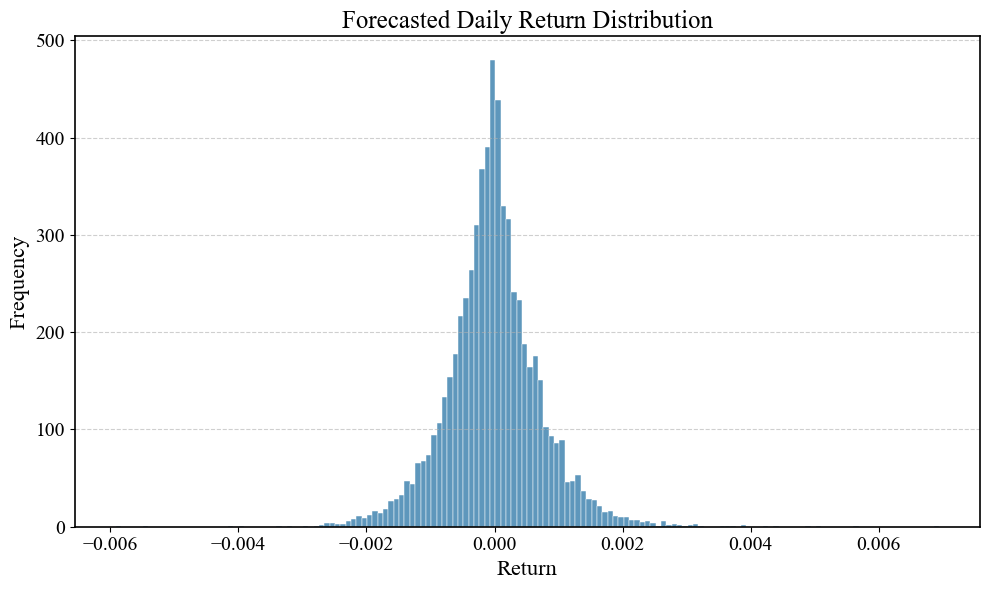

In [19]:
# Create styled figure and axis
fig, ax = plt.subplots(figsize=plot_style.get_figsize("wide"))

# Plot histogram using Seaborn
sns.histplot(pd_predictions['forecast'], ax=ax, color="#2874A6", edgecolor="white")

ax.set_title("Forecasted Daily Return Distribution")
ax.set_xlabel("Return")
ax.set_ylabel("Frequency")

# Apply your custom style
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)

In [20]:
# Import custom evaluation metrics
from genai4t.evaluation.metrics import (
    compute_investment_scores,
    get_cumulative_returns)

In [21]:
scores = (
    pd_predictions
    .groupby(['item_id'])
    .apply(
        lambda df: pd.Series(compute_investment_scores(df["target"], df["forecast"])))
    .reset_index()
)

In [22]:
scores

,item_id,mean,std,sharpe,cum_return,spearman_corr
0,currency_1,0.000164,0.006252,0.416175,0.140676,0.016516
1,currency_2,0.000002,0.005931,0.004238,0.001272,-0.000217
2,currency_3,0.000109,0.004936,0.350651,0.091508,0.026177
3,currency_4,-0.000261,0.007268,-0.569500,-0.188906,-0.017308
4,currency_5,0.000180,0.001715,1.667651,0.155697,0.069523
5,currency_6,-0.000039,0.005817,-0.107205,-0.031053,-0.011102
6,currency_7,0.000097,0.006986,0.219885,0.080807,-0.004603
7,currency_8,0.000106,0.003417,0.492570,0.088867,-0.004063


In [23]:
scores['cum_return'].sum()

0.33886945247650146

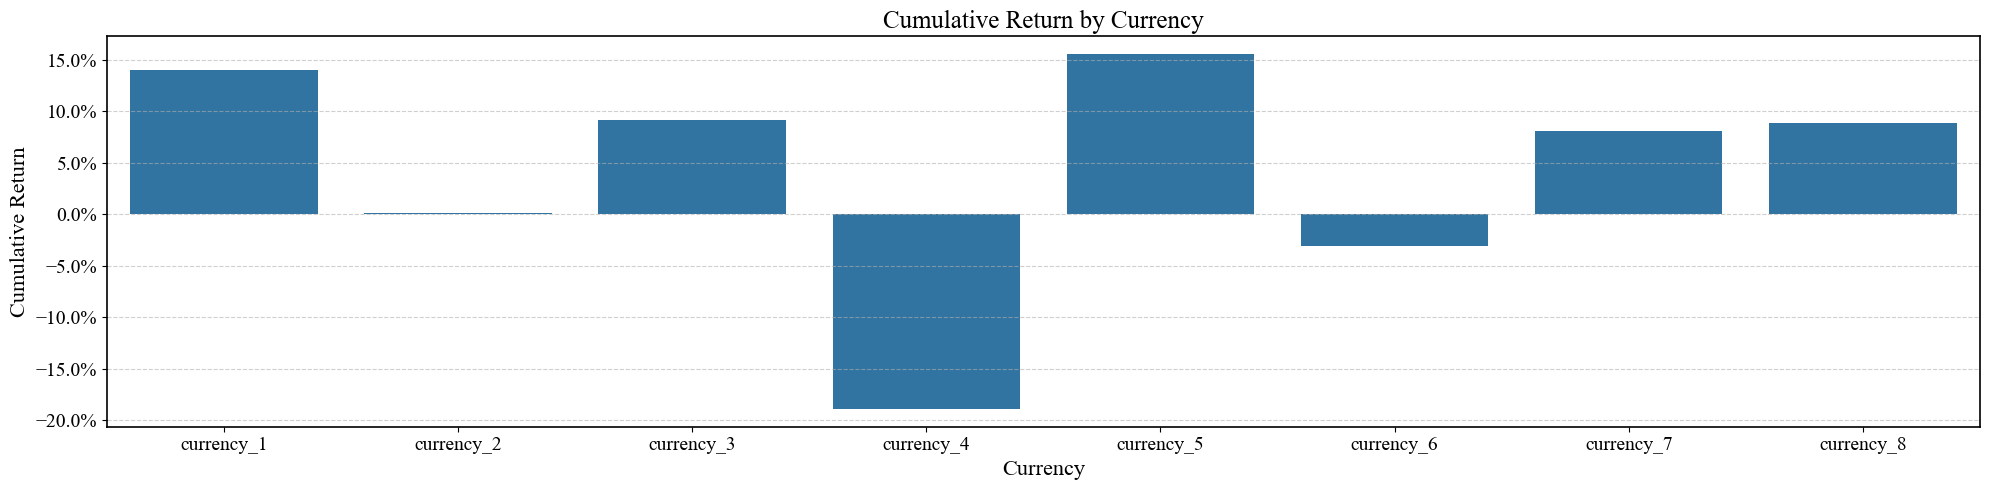

In [24]:
import matplotlib.ticker as mtick  
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='item_id', y='cum_return', data=scores)
ax.set_title("Cumulative Return by Currency")
ax.set_xlabel("Currency")
ax.set_ylabel("Cumulative Return")

# Format y-axis as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

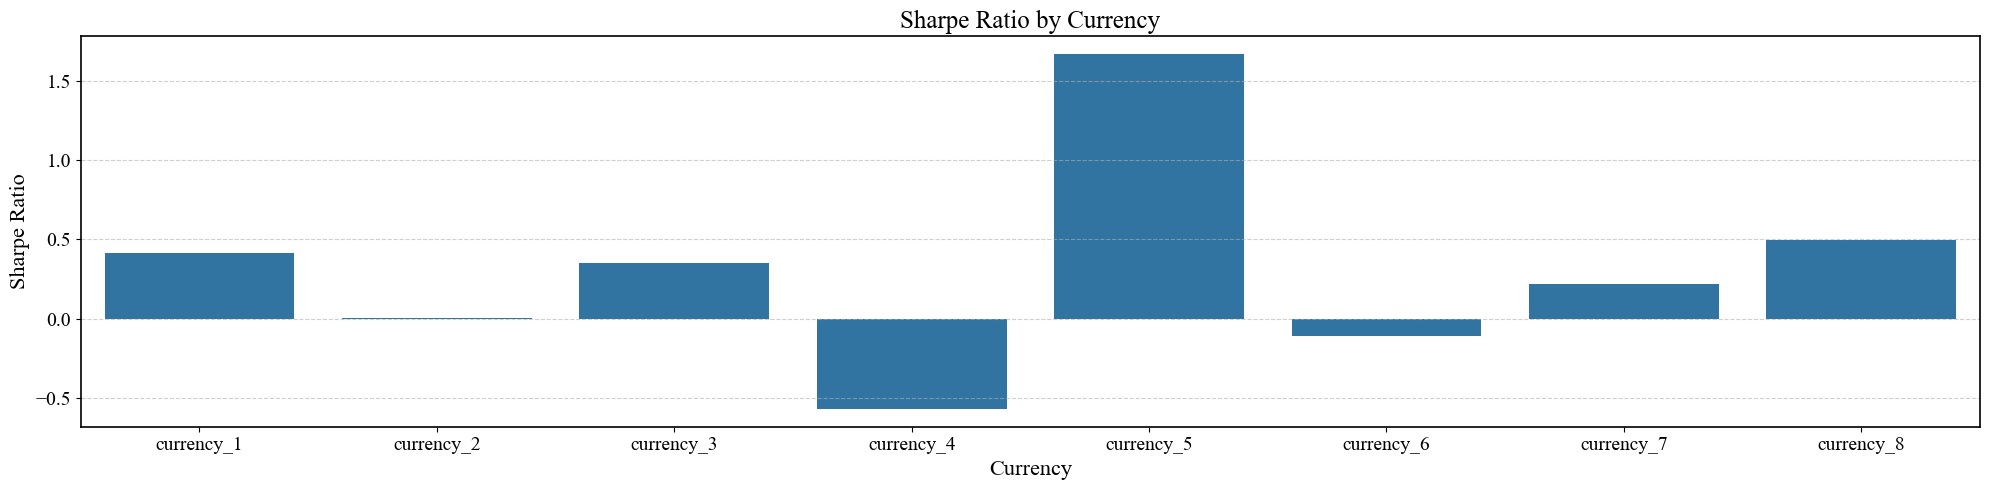

In [25]:
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='item_id', y='sharpe', data=scores)
ax.set_title("Sharpe Ratio by Currency")
ax.set_xlabel("Currency")
ax.set_ylabel("Sharpe Ratio")

plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

In [26]:
pd_predictions['cum_return'] = (
    pd_predictions
    .groupby(['item_id'], group_keys=False)
    .apply(lambda df: get_cumulative_returns(df['target'], df['forecast']))
)

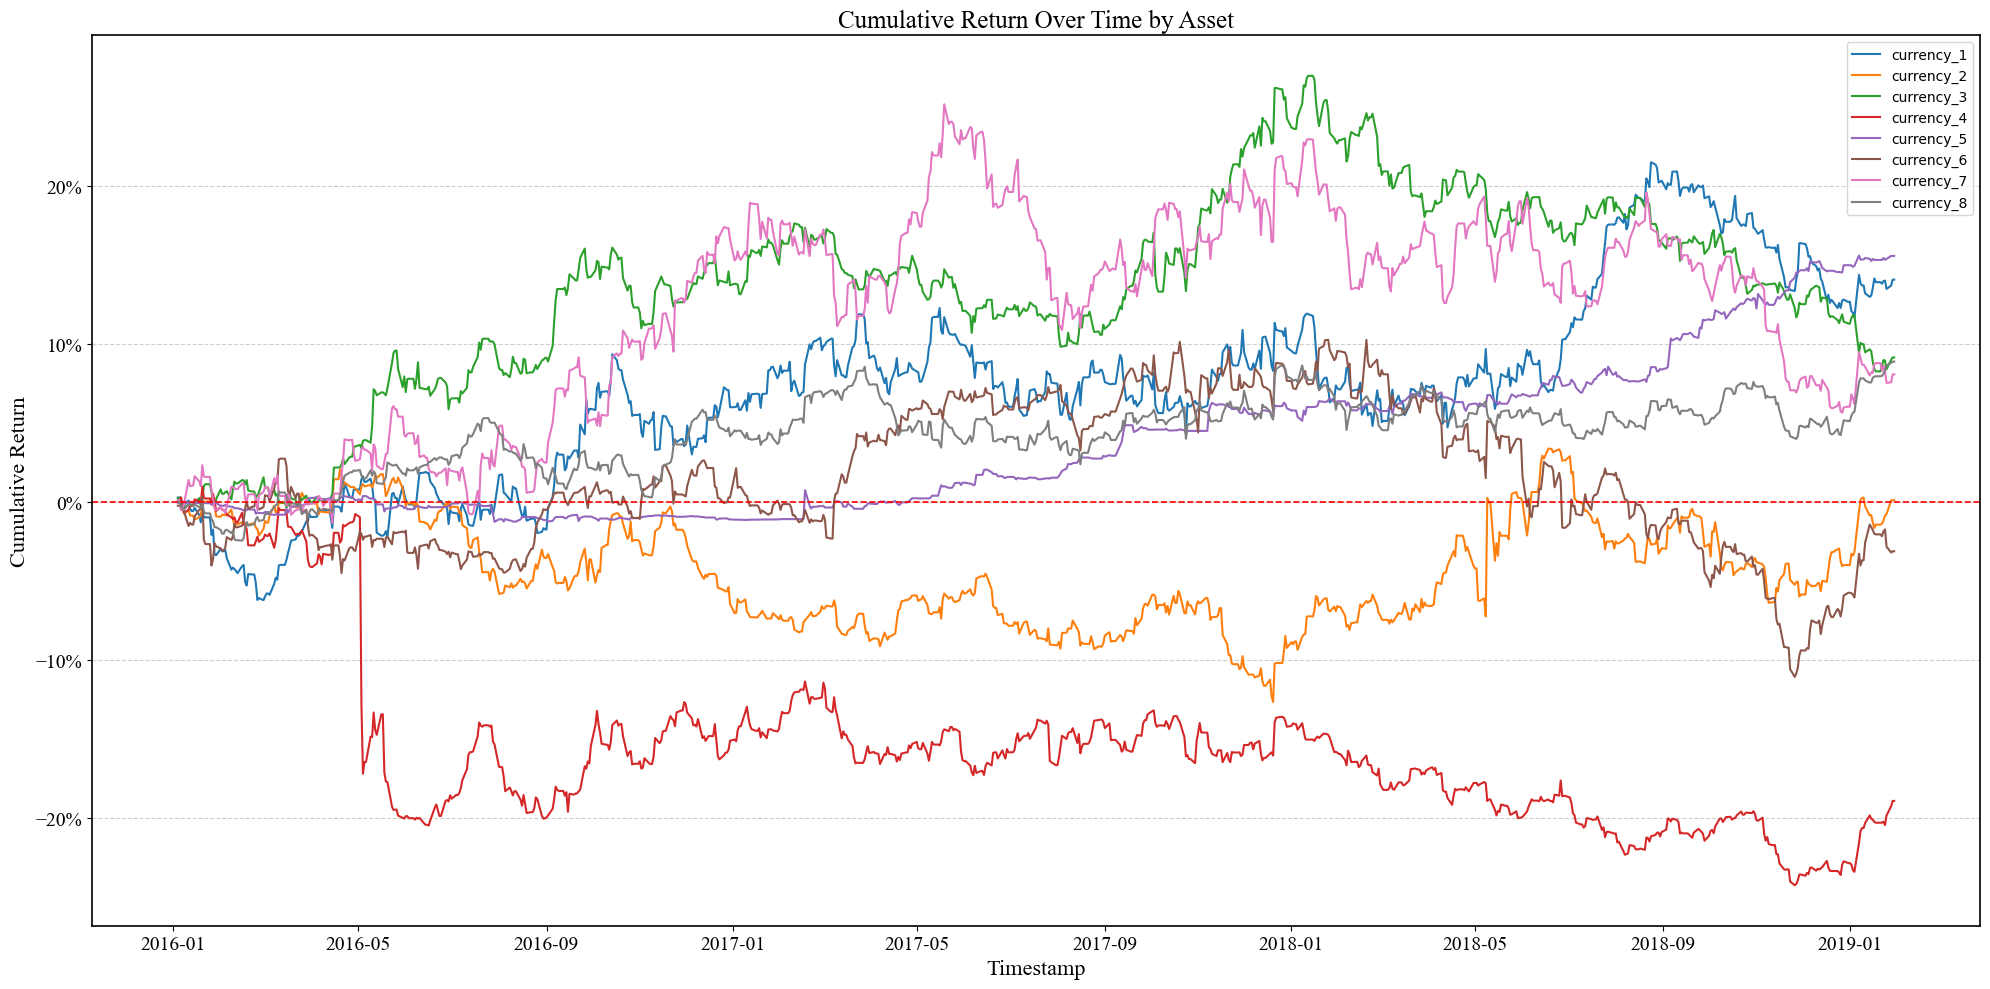

In [27]:
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    x="timestamp",
    y='cum_return',
    hue='item_id',
    data=pd_predictions.reset_index(),
    ax=ax)

# Horizontal reference line at 0%
ax.axhline(0., color='red', linestyle='--', linewidth=1.2)


# Format y-axis as percentages (assuming cum_return is in decimal form)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


# Title and labels
ax.set_title("Cumulative Return Over Time by Asset")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Cumulative Return")

# Apply custom styling
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

# Handle legend (optional: move outside if too crowded)
ax.legend(loc="best")